In [1]:
from torch.nn import Sequential
from torch import nn
import torch

from torchvision import transforms, datasets

In [2]:
#load the mnsit dataset
dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)

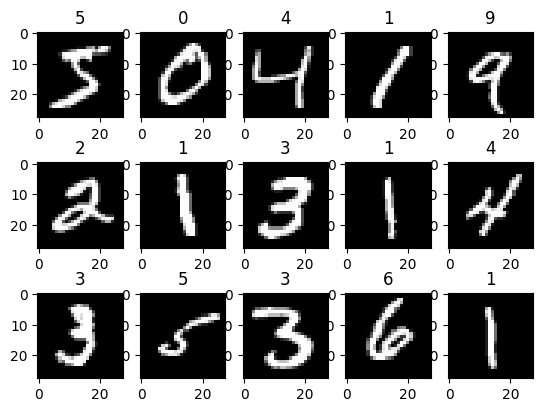

In [3]:
#display some examples from the dataset
import matplotlib.pyplot as plt
%matplotlib inline


#display the first 15 images in the dataset
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(dataset.data[i].numpy(), cmap='gray')
    plt.title('%i' % dataset.targets[i])


In [4]:
 #test split the dataset
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(dataset.data, dataset.targets, test_size=0.2, random_state=42)

In [5]:
#normalize train_data and test_data
train_data = train_data/255.0
test_data = test_data/255.0

In [6]:
generator_losses_train = []
discriminator_losses_train = []
generator_losses_test = []
discriminator_losses_test = []




In [11]:


#The main class for GANs 
class generator():
    def __init__(self, input_shape,hidden_shapes,output_shape):

        self.input_shape = input_shape
        self.model = Sequential(
            nn.Linear(input_shape,hidden_shapes[0]),
            nn.SiLU(),
            nn.Linear(hidden_shapes[0],hidden_shapes[1]),
            nn.SiLU(),
            nn.Linear(hidden_shapes[1],output_shape),
            nn.Sigmoid()

        )

    def forward(self,img):
        x = self.model(img)
        return x

class discriminator():
    def __init__(self, input_shape,hidden_shapes):
        self.input_shape = input_shape
        self.model = Sequential(
            nn.Linear(input_shape,hidden_shapes[0]),
            nn.SiLU(),
            nn.Linear(hidden_shapes[0],hidden_shapes[1]),
            nn.SiLU(),
            nn.Linear(hidden_shapes[1],1),
            nn.Sigmoid()
        )

        

    def forward(self,img):
        x = self.model(img)
        return x

class GAN():
    def __init__(self,img_width,img_height,hidden_shapes_generator,hidden_shapes_discriminator,input_shape = 100, output_shape = None,batch_size= 64):
        if output_shape == None:
            output_shape = img_width*img_height
        self.input_shape = input_shape

        self.generator = generator(input_shape,hidden_shapes_generator,output_shape)
        self.discriminator = discriminator(output_shape,hidden_shapes_discriminator)
        self.loss = nn.BCELoss()
        self.generator_optimizer = torch.optim.Adam(self.generator.model.parameters(),lr=0.002)
        self.discriminator_optimizer = torch.optim.Adam(self.discriminator.model.parameters(),lr=0.002)
        self.batch_size = batch_size   
        self.real_labels =  torch.ones(self.batch_size).reshape(-1, 1)
        self.fake_labels = torch.zeros(self.batch_size).reshape(-1, 1)


    def train(self,train_data,epochs=10):
        for epoch in range(epochs):
            noises = torch.rand(len(train_data),self.input_shape).float()
            for i in range(0,len(train_data),self.batch_size):

                # Create noisy input for generator between 0 and 1

                        # zero the gradients on each iteration
                self.generator_optimizer.zero_grad()

                # Create noisy input for generator
                # Need float type instead of int

                generated_data = self.generator.model(noises[i:i+self.batch_size])

                # Generate examples of even real data
                true_data = train_data[i:i+self.batch_size].view(-1,28*28).float()


                # Train the generator
                # We invert the labels here and don't train the discriminator because we want the generator
                # to make things the discriminator classifies as true.
                generator_discriminator_out = self.discriminator.model(generated_data)
                generator_loss = self.loss(generator_discriminator_out, self.real_labels)
                generator_loss.backward()
                self.generator_optimizer.step()

                # Train the discriminator on the true/generated data
                self.discriminator_optimizer.zero_grad()
                true_discriminator_out = self.discriminator.model(true_data)
                true_discriminator_loss = self.loss(true_discriminator_out, self.real_labels)

                # add .detach() here think about this
                # Train the discriminator
                self.discriminator_optimizer.zero_grad()
                true_discriminator_out = self.discriminator.model(true_data)
                true_discriminator_loss = self.loss(true_discriminator_out, self.real_labels)
                generator_discriminator_out = self.discriminator.model(generated_data.detach())
                generator_discriminator_loss = self.loss(generator_discriminator_out,self.fake_labels)
                discriminator_loss = (true_discriminator_loss + generator_discriminator_loss) / 2
    
                discriminator_loss.backward()
                self.discriminator_optimizer.step()
                generator_losses_train.append(generator_loss.item())
                discriminator_losses_train.append(discriminator_loss.item()) 
            #show some generated examples in a grid 
            if epoch%5 == 0:
                #test the generator on the test set and calculate the loss
                noises = torch.rand(len(test_data),self.input_shape).float()
                generated_data = self.generator.model(noises)
                true_data = test_data.view(-1,28*28).float()
                #shuffle the test data
                true_data = true_data[torch.randperm(true_data.size()[0])]
                generator_discriminator_out = self.discriminator.model(generated_data)
                discriminator_discriminator_out = self.discriminator.model(true_data)
                for i in range(0,len(test_data),self.batch_size):
                    generator_loss = self.loss(generator_discriminator_out[i:i+self.batch_size], self.real_labels[:min(self.batch_size,len(test_data)-i)])
                    generator_losses_test.append(generator_loss.item())
                    discriminator_loss = self.loss(discriminator_discriminator_out[i:i+self.batch_size], self.real_labels[:min(self.batch_size,len(test_data)-i)])
                    discriminator_losses_test.append(discriminator_loss.item())

                print("Epoch: ", epoch)
                print("Generator loss: ", generator_loss.item())
                print("Discriminator loss: ", discriminator_loss.item())
                noises = torch.randn(8, self.input_shape).float()
                generated_data = self.generator.model(noises)

                fig, axs = plt.subplots(1,8, figsize=(20, 2), dpi=80)
                fig.subplots_adjust(wspace=0, hspace=0)

                for i, ax in enumerate(axs.ravel()):
                    ax.imshow(generated_data[i].detach().numpy().reshape(28, 28), cmap='gray')
                    ax.axis('off')

                plt.show()


In [12]:
#initialize the GAN
gan = GAN(28,28,[256,128],[256,128])

#train the GAN
gan.train(train_data,epochs=50)


ValueError: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.

In [59]:
import math 
#import Tuple List
from typing import Tuple, List
import numpy as np 

In [60]:

def create_binary_list_from_int(number: int) -> List[int]:
    if number < 0 or type(number) is not int:
        raise ValueError("Only Positive integers are allowed")

    return [int(x) for x in list(bin(number))[2:]]

In [61]:

def generate_even_data(max_int: int, batch_size: int=16) -> Tuple[List[int], List[List[int]]]:
    # Get the number of binary places needed to represent the maximum number
    max_length = int(math.log(max_int, 2))

    # Sample batch_size number of integers in range 0-max_int
    sampled_integers = np.random.randint(0, int(max_int / 2), batch_size)

    # create a list of labels all ones because all numbers are even
    labels = [1] * batch_size

    # Generate a list of binary numbers for training.
    data = [create_binary_list_from_int(int(x * 2)) for x in sampled_integers]
    data = [([0] * (max_length - len(x))) + x for x in data]

    return labels, data

In [62]:
class Discriminator(nn.Module):
    def __init__(self, input_length: int):
        super(Discriminator, self).__init__()
        self.dense = nn.Linear(int(input_length), 1);
        self.activation = nn.Sigmoid()

    def forward(self, x):
        return self.activation(self.dense(x))

In [63]:

class Generator(nn.Module):

    def __init__(self, input_length: int):
        super(Generator, self).__init__()
        self.dense_layer = nn.Linear(int(input_length), int(input_length))
        self.activation = nn.Sigmoid()

    def forward(self, x):
        return self.activation(self.dense_layer(x))

In [76]:
import math

import torch
import torch.nn as nn


def train(max_int: int = 128, batch_size: int = 16, training_steps: int = 500):
    input_length = int(math.log(max_int, 2))

    # Models
    generator = Generator(input_length)
    discriminator = Discriminator(input_length)

    # Optimizers
    generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)
    discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)

    # loss
    loss = nn.BCELoss()

    for i in range(training_steps):
        # zero the gradients on each iteration
        generator_optimizer.zero_grad()

        # Create noisy input for generator
        # Need float type instead of int
        noise = torch.randint(0, 2, size=(batch_size, input_length)).float()
        generated_data = generator(noise)

        # Generate examples of even real data
        true_labels, true_data = generate_even_data(max_int, batch_size=batch_size)
        true_labels = torch.tensor(true_labels).float()
        true_data = torch.tensor(true_data).float()

        # Train the generator
        # We invert the labels here and don't train the discriminator because we want the generator
        # to make things the discriminator classifies as true.
        generator_discriminator_out = discriminator(generated_data)
        generator_loss = loss(generator_discriminator_out, true_labels.reshape(-1, 1))
        generator_loss.backward()
        generator_optimizer.step()

        # Train the discriminator on the true/generated data
        discriminator_optimizer.zero_grad()
        true_discriminator_out = discriminator(true_data)
        true_discriminator_loss = loss(true_discriminator_out, true_labels.reshape(-1, 1))

        # add .detach() here think about this
        # Train the discriminator
        discriminator_optimizer.zero_grad()
        true_discriminator_out = discriminator(true_data)
        true_discriminator_loss = loss(true_discriminator_out, torch.ones(batch_size).reshape(-1, 1))
        generator_discriminator_out = discriminator(generated_data.detach())
        generator_discriminator_loss = loss(generator_discriminator_out, torch.zeros(batch_size).reshape(-1, 1))
        discriminator_loss = (true_discriminator_loss + generator_discriminator_loss) / 2
        print (generator_discriminator_loss, true_discriminator_loss)
        discriminator_loss.backward()
        discriminator_optimizer.step()


In [77]:
#train the GAN
train()


tensor(1.0812, grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.4953, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.0749, grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.5362, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.0673, grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.5159, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.0817, grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.5037, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.0788, grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.5287, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.0748, grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.5000, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.0634, grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.5282, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.0606, grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.5336, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.0668, grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.5398, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.0657, grad_fn=<Bina